In [ ]:
# ISS-VSE CA1

In [147]:
import os
import random as rand
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import copy

import imgaug as ia
from imgaug import augmenters as iaa

from YOLO_API import *
from voc import *
import xml.etree.ElementTree as ET
from keras.utils import Sequence

### Read all image and VOC dataset

In [148]:
def read_annotation_files(image_dir, annnotation_dir):
    all_annotations = []
    labels = {}
    for anno in sorted(os.listdir(annnotation_dir)):
        img = {'object':[]}
        try:
            xml_tree = ET.parse(annnotation_dir + anno)
        except Exception as ex:
            print(ex)
            print(f'Error parsing annotation xml: {annnotation_dir + anno}')
            continue
        for elem in xml_tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = image_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag:
                obj = {}
                for attribute in list(elem):
                    if 'name' in attribute.tag:
                        obj['name'] = attribute.text
                        if obj['name'] in labels:
                            labels[obj['name']] += 1
                        else:
                            labels[obj['name']] = 1
                        img['object'] += [obj]
                    if 'bndbox' in attribute.tag:
                        for dim in list(attribute):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))
        if len(img['object']) > 0:
            bb_list = []
            for obj in img['object']:
                bb_list.append(ia.BoundingBox(x1=obj['xmin'], y1=obj['ymin'], x2=obj['xmax'], y2=obj['ymax'], label=obj['name']))
            img['bbs'] = ia.BoundingBoxesOnImage(bb_list, shape=(img['width'], img['height']))
            all_annotations += [img]
    return all_annotations, labels

In [149]:
#Reference https://www.kaggle.com/mpalermo/keras-pipeline-custom-generator-imgaug
class DataGenerator(Sequence):
    '''Generate data with augmentations using Keras Util Sequence API
        Required Methods:
        def __init__(self)
        def __len__(self)
        def on_epoch_end(self)
        def __getitem__(self)'''

    def __init__(self, image_path, labels, anchors, batch_size=32, image_dims=(416, 416, 3), shuffle=False, augment=True):
        self.image_path=image_path
        self.labels=labels
        self.anchors=anchors
        self.batch_size=batch_size
        self.image_dims=image_dims
        self.shuffle=shuffle
        self.augment=augment

        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_path)/self.batch_size))
    
    def on_epoch_end(self):
        '''Update index after each epoch'''
        self.index = np.arange(len(self.image_path))
        if self.shuffle:
            np.random.shuffle(self.index)
    
    def augment_with_bb(self, images, boundingbox):
        seq = iaa.Sequential([
            iaa.AdditiveGaussianNoise(scale=0.05*255),
            iaa.Affine(translate_px={"x": (1, 5)})
        ])
        return seq(images=images, bounding_boxes=boundingbox)
    
    def __getitems__(self, index):
        pass

In [150]:
trainimgfolder = "../data/image/"
trainannotatefolder = "../data/annotation/"
train_ints, labels = read_annotation_files(trainimgfolder, trainannotatefolder)
labels_unqiue = labels.keys()

In [151]:
labels

{'car': 2495, 'bus': 217}

In [8]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].x1 = int((boxes[i].x1 - x_offset) / x_scale * image_w)
        boxes[i].x2 = int((boxes[i].x2 - x_offset) / x_scale * image_w)
        boxes[i].y1 = int((boxes[i].y1 - y_offset) / y_scale * image_h)
        boxes[i].y2 = int((boxes[i].y2 - y_offset) / y_scale * image_h)

In [9]:
def apply_random_scale_and_crop(image, new_w, new_h, net_w, net_h, dx, dy):
    im_sized = cv2.resize(image, (new_w, new_h))
    
    if dx > 0: 
        im_sized = np.pad(im_sized, ((0,0), (dx,0), (0,0)), mode='constant', constant_values=127)
    else:
        im_sized = im_sized[:,-dx:,:]
    if (new_w + dx) < net_w:
        im_sized = np.pad(im_sized, ((0,0), (0, net_w - (new_w+dx)), (0,0)), mode='constant', constant_values=127)
               
    if dy > 0: 
        im_sized = np.pad(im_sized, ((dy,0), (0,0), (0,0)), mode='constant', constant_values=127)
    else:
        im_sized = im_sized[-dy:,:,:]
        
    if (new_h + dy) < net_h:
        im_sized = np.pad(im_sized, ((0, net_h - (new_h+dy)), (0,0), (0,0)), mode='constant', constant_values=127)
        
    return im_sized[:net_h, :net_w,:]   

In [10]:
seq = iaa.Sequential([
    iaa.GammaContrast(1.5),
#     iaa.Affine(translate_px={"x": (1, 5)})
    iaa.Resize({'height':416, 'width':416})
])

In [11]:
def limit_constraint(value, minVal, maxVal):
    if value < minVal:
        return minVal
    if value > maxVal:
        return maxVal
    return value

In [12]:
def scale_boxes(boxes, img_height, img_width, new_height, new_width):
    all_boxes = copy.deepcopy(boxes)
    sx, sy = float(new_width) / img_width, float(new_height) / img_height
    box_list = []
    for box in boxes.bounding_boxes:
        scale_box = ia.BoundingBox(
            x1=int(limit_constraint(0, new_width, box.x1 * sx)),
            x2=int(limit_constraint(0, new_width, box.x2 * sx)),
            y1=int(limit_constraint(0, new_height, box.y1 * sy)),
            y2=int(limit_constraint(0, new_height, box.y2 * sy)),
            label=box.label)
        if (scale_box.x2 <= scale_box.x1 or scale_box.y2 <= scale_box.y1):
            continue
        box_list.append(scale_box)
    return ia.BoundingBoxesOnImage(box_list, (new_width, new_height))

In [13]:
dx = int(np.random.uniform(0, 608-416))
dy = int(np.random.uniform(0, 608-416))
scale = np.random.uniform(0.25,2)
new_h = int(scale * 416)
new_h

558

In [14]:
img = cv2.imread(train_ints[0]['filename'])
# img_aug, bbs_aug = seq(image=img, bounding_boxes=train_ints[0]['bbs'])
# img_aug = seq.augment_image(img)
# bbs_aug = seq.augment_bounding_boxes(train_ints[0]['bbs'])
# bbs_aug
# img2 = apply_random_scale_and_crop(img, 608, 608, 608, 608, dx, dy)
# bbs = correct_yolo_boxes(train_ints[0]['bbs'].bounding_boxes, 608, 608, 608, 608)

img = img[:,:,::-1]
img_h, img_w,_ = img.shape

TypeError: 'NoneType' object is not subscriptable

In [15]:
img_aug, bbs_aug = seq(image=img, bounding_boxes=train_ints[0]['bbs'])
img_aug = seq.augment_image(img)
bbs_aug = seq.augment_bounding_boxes(train_ints[0]['bbs'])

In [17]:
bbs_aug

BoundingBoxesOnImage([BoundingBox(x1=492.8444, y1=128.0500, x2=592.8000, y2=157.9500, label=car)], shape=(416, 416))

In [37]:
sbb = ia.BoundingBoxesOnImage(box_list, (1280,720))

In [38]:
testbox = ia.BoundingBox()

BoundingBoxesOnImage([BoundingBox(x1=212.0000, y1=403.0000, x2=485.0000, y2=499.0000, label=car), BoundingBox(x1=550.0000, y1=416.0000, x2=629.0000, y2=446.0000, label=car), BoundingBox(x1=634.0000, y1=413.0000, x2=721.0000, y2=449.0000, label=car), BoundingBox(x1=718.0000, y1=408.0000, x2=896.0000, y2=451.0000, label=car), BoundingBox(x1=1157.0000, y1=357.0000, x2=1280.0000, y2=526.0000, label=car)], shape=(1280, 720))

In [90]:
bbs_aug

BoundingBoxesOnImage([BoundingBox(x1=212.0000, y1=403.0000, x2=485.0000, y2=499.0000, label=car), BoundingBox(x1=550.0000, y1=416.0000, x2=629.0000, y2=446.0000, label=car), BoundingBox(x1=634.0000, y1=413.0000, x2=721.0000, y2=449.0000, label=car), BoundingBox(x1=718.0000, y1=408.0000, x2=896.0000, y2=451.0000, label=car), BoundingBox(x1=1157.0000, y1=357.0000, x2=1280.0000, y2=526.0000, label=car)], shape=(1280, 720))

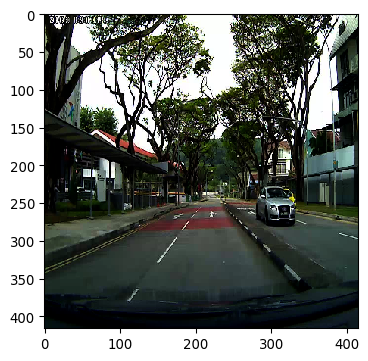

In [18]:
ia.imshow(bbs_aug.draw_on_image(img_aug))
# ia.imshow(train_ints[0]['bbs'].draw_on_image(img_aug))

In [87]:
testimg = img_aug
testbbs = bbs_aug
bbs_aug

BoundingBoxesOnImage([BoundingBox(x1=212.0000, y1=403.0000, x2=485.0000, y2=499.0000, label=car), BoundingBox(x1=550.0000, y1=416.0000, x2=629.0000, y2=446.0000, label=car), BoundingBox(x1=634.0000, y1=413.0000, x2=721.0000, y2=449.0000, label=car), BoundingBox(x1=718.0000, y1=408.0000, x2=896.0000, y2=451.0000, label=car), BoundingBox(x1=1157.0000, y1=357.0000, x2=1280.0000, y2=526.0000, label=car)], shape=(1280, 720))

In [83]:
testimgs = cv2.resize(testimg, (608,608))
# testbbss = scale_boxes(testbbs, testimg.shape[0], testimg.shape[1], 608, 608)

In [95]:
# ia.imshow(testbbss.draw_on_image(testimgs))
xScale = 608 / testimg.shape[1]
yScale = 608 / testimg.shape[0]
box_list = []
for box in testbbs.bounding_boxes:
    scale_box = ia.BoundingBox(
        x1=int(np.round(box.x1 * xScale)),
        x2=int(np.round(box.x2 * xScale)),
        y1=int(np.round(box.y1 * yScale)),
        y2=int(np.round(box.y2 * yScale)),
        label=box.label)
    box_list.append(scale_box)
newbbs = ia.BoundingBoxesOnImage(box_list, (608,608))
# sx, sy = int(np.round(testbbs.bounding_boxes[0].x1 * xScale)), int(np.round(testbbs.bounding_boxes[0].y1 * yScale))
# sXmax, sYmax = int(np.round(testbbs.bounding_boxes[0].y1 * yScale)), int(np.round(testbbs.bounding_boxes[0].y2 * yScale))
# limit_constraint(0, 608, testbbs[0].x1 * )
# limit_constraint(0, 608, testbbs.bounding_boxes[0].x1 * sx)
# limit_constraint(0, 608, testbbs.bounding_boxes[0].x2 * sx)

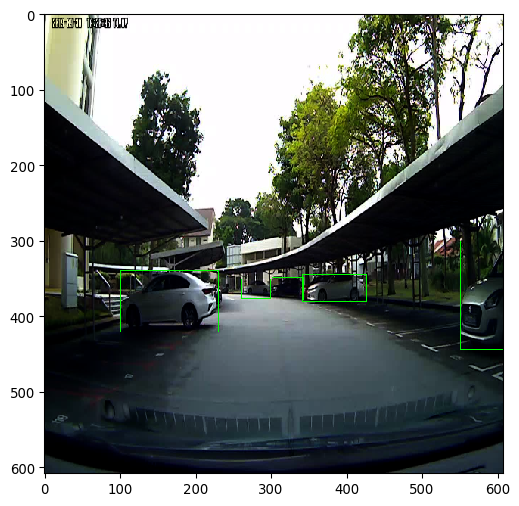

In [97]:
ia.imshow(newbbs.draw_on_image(testimgs))
# testbbs.bounding_boxes

In [9]:
# class BoundingBox:
#     '''Bounding Box definition'''
#     def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
#         self.xmin=xmin
#         self.ymin=ymin
#         self.xmax=xmax
#         self.ymax=ymax
#         self.c=c
#         self.classes=classes
#         self.label = None
#         self.score = None
#     def get_label(self):
#         if self.label == None:
#             self.label = np.argmax(self.classes)
#         return self.label
#     def get_score(self):
#         if self.score == None:
#             self.score = self.classes[self.get_label()]
#         return self.score
# def interval_overlap(interval_a, interval_b):
#     x1, x2 = interval_a
#     x3, x4 = interval_b
    
#     if x3 < x1:
#         if x4 < x1:
#             return 0
#         else:
#             return min(x2, x4) - x1
#     else:
#         if x2 < x3:
#             return 0
#         else:
#             return min(x2, x4) - x3

# def boundbox_iou(bx1, bx2):
#     intsec_w = interval_overlap([bx1.xmin, bx2.xmax], [bx2.xmin, bx2.xmax])
#     intsec_h = interval_overlap([bx1.ymin, bx2.ymax], [bx2.ymin, bx2.ymax])
#     intsec = intsec_w * intsec_h
#     w1, h1 = bx1.xmax-bx1.xmin, bx1.ymax-bx1.ymin
#     w2, h2 = bx2.xmax-bx2.xmin, bx2.ymax-bx2.ymin
#     union = w1*h1 + w2*h2 - intsec
#     return float(intsec)/union

In [10]:
bbs_aug.bounding_boxes

[BoundingBox(x1=283.0000, y1=226.0000, x2=345.0000, y2=286.0000, label=car)]

In [11]:
bbs_aug.bounding_boxes[1].label

IndexError: list index out of range

In [ ]:
labels = ['car', 'bus']
labels.index(bbs_aug.bounding_boxes[1].label)

In [ ]:
iou = bbs_aug.bounding_boxes[0].iou(bbs_aug.bounding_boxes[1])
print(iou)

In [ ]:
anchors = fulltest|
anchors

In [ ]:
for i in range(len(anchors)//2):
    print(str(anchors[2*i]) + ', ' + str(anchors[2*i+1]))

In [ ]:
for b in bbs_aug.bounding_boxes:
    print(b.x1)

In [ ]:
an1 = ia.BoundingBox(x1=0.0,y1=0.0,x2=anchors[0][0],y2=anchors[0][1])
bb1 = ia.BoundingBox(x1=0.0,y1=0.0,x2=bbs_aug.bounding_boxes[0].x2,y2=bbs_aug.bounding_boxes[0].y2)
ioutest = bb1.iou(an1)
ioutest

In [ ]:
bb = bbs_aug.bounding_boxes[1]
bb.x1

In [ ]:
for bb in bbs_aug.bounding_boxes:
    max_anchor = None
    max_index = -1
    max_iou = -1
    for i in range(len(anchors)):
        ach = anchors[i]
        iou = bb.iou(ach)

In [ ]:
def calculate_iou(anno, centroids):
    anno_width, anno_height = anno
    iou_list = []
    anno_area = anno_width * anno_height
    for cent in centroids:
        cent_width, cent_height = cent
        if cent_width <= anno_width and cent_height >= anno_height:
            iou = cent_width * anno_height / (anno_area + cent_width * (cent_height - anno_height))
        elif cent_width >= anno_width and cent_height >= anno_height:
            iou = anno_area / (cent_width * cent_height)
        elif cent_width >= anno_width and cent_height <= anno_height:
            iou = anno_width * cent_height / (anno_area + (cent_width - anno_width) * cent_height)
        else:
            iou = (cent_width * cent_height) / anno_area
        iou_list.append(iou)
    return np.array(iou_list)

In [ ]:
annotations_dim = []
num_anchors = 9
for anno in train_ints:
    for obj in anno['object']:
        rel_width = (float(obj['xmax']) - float(obj['xmin'])) / anno['width']
        rel_height = (float(obj['ymax']) - float(obj['ymin'])) / anno['height']
        annotations_dim.append(tuple(map(float,(rel_width, rel_height))))


anno_arr = np.array(annotations_dim)
curr_assign_centroids = np.zeros(anno_arr.shape[0])
curr_distances = np.zeros((anno_arr.shape[0], num_anchors))

In [ ]:
len(annotations_dim)

In [ ]:
indexes = [rand.randrange(anno_arr.shape[0]) for anchor in range(num_anchors)]
sample_centroids = anno_arr[indexes]
final = sample_centroids.copy()
iterations = 0
while True:
    iterations += 1
    distances = []
    for idx in range(anno_arr.shape[0]):
        distance = 1 - calculate_iou(anno_arr[idx], sample_centroids)
        distances.append(distance)
    distances_arr = np.array(distances)
    print(f'iter: {iterations} distances: {np.sum(np.abs(curr_distances-distances_arr))}')
    assign_centroids = np.argmin(distances_arr, axis=1)
    if (assign_centroids == curr_assign_centroids).all():
        final = sample_centroids
        break
    centroid_sums = np.zeros((num_anchors, anno_arr.shape[1]), np.float)
    for idx in range(anno_arr.shape[0]):
        centroid_sums[assign_centroids[idx]] += anno_arr[idx]
    for idx in range(num_anchors):
        sample_centroids[idx] = centroid_sums[idx] / (np.sum(assign_centroids==idx) + 1e-6)
    curr_assign_centroids = assign_centroids.copy()
    curr_distances = distances_arr.copy()

In [ ]:
def print_anchors(centroids):
    out_string = ''

    anchors = centroids.copy()

    widths = anchors[:, 0]
    sorted_indices = np.argsort(widths)

    r = "anchors: ["
    for i in sorted_indices:
        out_string += str(int(anchors[i,0]*416)) + ',' + str(int(anchors[i,1]*416)) + ', '
            
    print(out_string[:-2])
print_anchors(final)

In [ ]:
test = final
# test
test = test[test[:,0].argsort()]
test

In [ ]:
fulltest=[]
for t in test:
    fulltest.append(((int(t[0]*416)),(int(t[1]*416))))

In [ ]:
fulltest

In [ ]:
def read_voc(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    list_with_all_boxes = []
    for boxes in root.iter('object'):
        filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None
        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)
        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)
    return filename, list_with_all_boxes

In [ ]:
# trainimgfolder = 'D:\\Workspace\\GitHub\\keras-yolo3\\data\\old_annotated_416x416\\'
# trainannotatefolder = 'D:\\Workspace\\GitHub\\keras-yolo3\\data\\old_raw_416x416\\'
trainimgfolder = "../data/image/"
trainannotatefolder = "../data/annotation/"
cache = 'D:\Workspace\GitHub\ISS-VSE-2019-09-23-IS1FT-CA1\data\cached'
labels = ['car','bus']
train_ints, train_labels = parse_voc_annotation(trainannotatefolder, trainimgfolder, cache, labels)

In [ ]:
max_box_per_image = max([len(inst['object']) for inst in (train_ints)])
max_box_per_image

In [ ]:
ann = os.listdir(trainannotatefolder)
ann[0]

In [ ]:
tree = ET.parse(trainannotatefolder+ann[4])

In [ ]:
tree

In [ ]:
seen_labels = {}
img = {'object':[]}
for elem in tree.iter():
    if 'filename' in elem.tag:
        img['filename'] = trainimgfolder + elem.text
    if 'width' in elem.tag:
        img['width'] = int(elem.text)
    if 'height' in elem.tag:
        img['height'] = int(elem.text)
    if 'object' in elem.tag or 'part' in elem.tag:
        obj = {}

        for attr in list(elem):
            if 'name' in attr.tag:
                obj['name'] = attr.text

                if obj['name'] in seen_labels:
                    seen_labels[obj['name']] += 1
                else:
                    seen_labels[obj['name']] = 1

                if len(labels) > 0 and obj['name'] not in labels:
                    break
                else:
                    img['object'] += [obj]

            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        obj['xmin'] = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        obj['ymin'] = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        obj['xmax'] = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        obj['ymax'] = int(round(float(dim.text)))

In [ ]:
seen_labels

In [ ]:
img

In [ ]:
TESt = img.copy()

In [ ]:
TESt += [img]

In [ ]:
allinst = []
allinst += [img]
allinst += [img]

In [ ]:
allinst

In [153]:
train_ints[310]

{'object': [{'name': 'car',
   'xmin': 165,
   'ymin': 399,
   'xmax': 311,
   'ymax': 457},
  {'name': 'car', 'xmin': 834, 'ymin': 381, 'xmax': 1037, 'ymax': 461}],
 'filename': '../data/image/a249.jpg',
 'width': 1280,
 'height': 720,
 'bbs': BoundingBoxesOnImage([BoundingBox(x1=165.0000, y1=399.0000, x2=311.0000, y2=457.0000, label=car), BoundingBox(x1=834.0000, y1=381.0000, x2=1037.0000, y2=461.0000, label=car)], shape=(1280, 720))}

In [169]:
fileName = train_ints[310]['filename']
imgT = cv2.imread(fileName)
# try:
#     if imgT == None:
#         newFile = fileName.replease('.jpg','.jpeg')
#         imgT = cv2.imread(newFile)
# except:
#     pass
imgT.shape

(720, 1280, 3)

In [170]:
bbs = train_ints[310]['bbs']
bbs

BoundingBoxesOnImage([BoundingBox(x1=165.0000, y1=399.0000, x2=311.0000, y2=457.0000, label=car), BoundingBox(x1=834.0000, y1=381.0000, x2=1037.0000, y2=461.0000, label=car)], shape=(1280, 720))

In [171]:
cv2.imshow('iomg',imgT)
cv2.waitKey(0)
cv2.destroyAllWindows()

height: 720
width: 1280


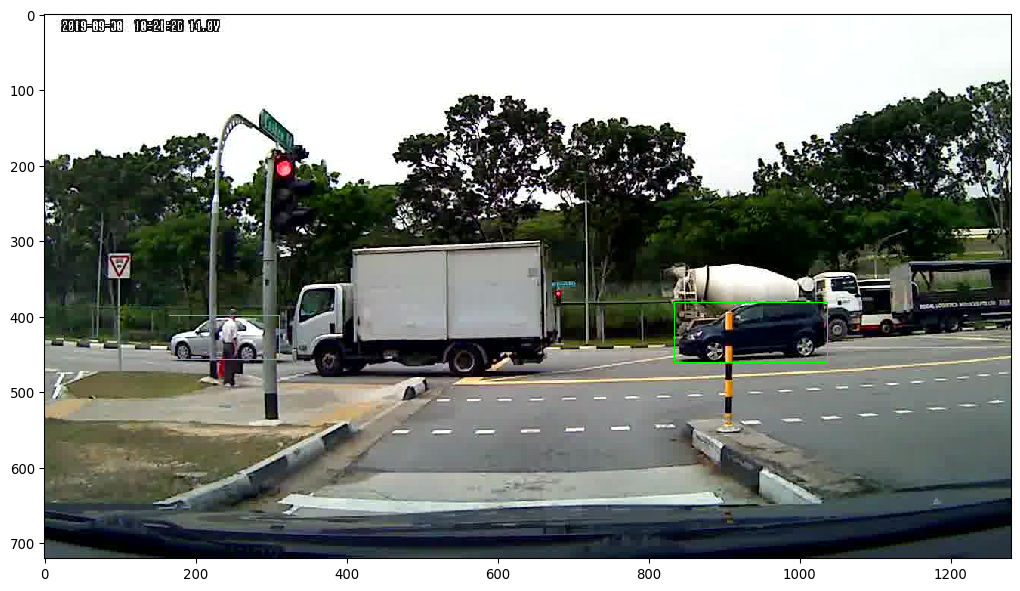

In [185]:
imgRGB = cv2.cvtColor(imgT, cv2.COLOR_BGR2RGB)
img_h, img_w, _ = imgRGB.shape
print(f'height: {img_h}')
print(f'width: {img_w}')
ia.imshow(bbs.draw_on_image(imgRGB))

In [173]:
new_aspect = (img_w/img_h)
new_aspect

1.7777777777777777

In [174]:
scale = np.random.uniform(0.25, 2)
scale

1.3391513326506148

In [175]:
h = int(scale*416)
w = int(416/new_aspect)

# h = int(scale*416)
# w = int(416*new_aspect)

print(f'h: {h}')
print(f'w: {w}')

h: 557
w: 234


In [187]:
h = int(scale*416) if new_aspect < 1 else int(416/new_aspect)
w = int(416 * new_aspect) if new_aspect < 1 else int(scale * 416)
print(f'h: {h}')
print(f'w: {w}')

h: 234
w: 557


In [188]:
dx = int(np.random.uniform(0, 416-w))
dy = int(np.random.uniform(0, 416-h))
print(f'dx: {dx}')
print(f'dy: {dy}')

dx: -47
dy: 135


In [197]:
def apply_random_scale_and_crop(image, new_w, new_h, net_w, net_h, dx, dy):
    im_sized = cv2.resize(image, (new_w, new_h))
    print(im_sized.shape)
    if dx > 0: 
        im_sized = np.pad(im_sized, ((0,0), (dx,0), (0,0)), mode='constant', constant_values=0)
    else:
        im_sized = im_sized[:,-dx:,:]
    if (new_w + dx) < net_w:
        im_sized = np.pad(im_sized, ((0,0), (0, net_w - (new_w+dx)), (0,0)), mode='constant', constant_values=0)
               
    if dy > 0: 
        im_sized = np.pad(im_sized, ((dy,0), (0,0), (0,0)), mode='constant', constant_values=0)
    else:
        im_sized = im_sized[-dy:,:,:]
        
    if (new_h + dy) < net_h:
        im_sized = np.pad(im_sized, ((0, net_h - (new_h+dy)), (0,0), (0,0)), mode='constant', constant_values=0)
        
    return im_sized[:net_h, :net_w,:]     

(234, 557, 3)
(416, 416, 3)


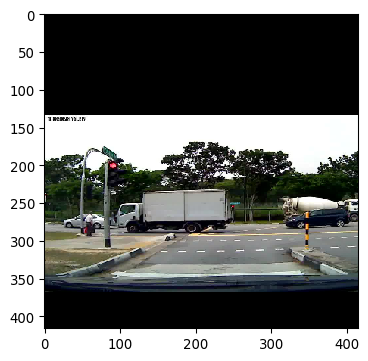

In [198]:
final_img = apply_random_scale_and_crop(imgRGB, w, h, 416, 416, dx, dy)
print(final_img.shape)
# cv2.imshow('fi',final_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
ia.imshow(final_img)

In [191]:
def _constrain(min_v, max_v, value):
    if value < min_v: return min_v
    if value > max_v: return max_v
    return value 
def correct_bounding_boxes(boxes, new_w, new_h, net_w, net_h, dx, dy, image_w, image_h):
    boxes = copy.deepcopy(boxes)
    boundboxes = boxes.bounding_boxes
    # randomize boxes' order
#     np.random.shuffle(boxes)

    # correct sizes and positions
    sx, sy = float(new_w)/image_w, float(new_h)/image_h
    zero_boxes = []

#     for i in range(len(boundboxes)):
    for idx in range(len(boundboxes)):
        boundboxes[idx].x1 = int(_constrain(0, net_w, boundboxes[idx].x1*sx + dx))
        boundboxes[idx].x2 = int(_constrain(0, net_w, boundboxes[idx].x2*sx + dx))
        boundboxes[idx].y1 = int(_constrain(0, net_h, boundboxes[idx].y1*sy + dy))
        boundboxes[idx].y2 = int(_constrain(0, net_h, boundboxes[idx].y2*sy + dy))

        if boundboxes[idx].x2 <= boundboxes[idx].x1 or boundboxes[idx].y2 <= boundboxes[idx].y1:
            zero_boxes += idx
            continue

#         if flip == 1:
#             swap = boxes[i].x1;
#             boxes[i].x1 = net_w - boxes[i].x2
#             boxes[i].x2 = net_w - swap

    boxes = [boundboxes[i] for i in range(len(boundboxes)) if i not in zero_boxes]

    return ia.BoundingBoxesOnImage(boxes, (net_w, net_h))

In [192]:
bbs.bounding_boxes[0]

BoundingBox(x1=165.0000, y1=399.0000, x2=311.0000, y2=457.0000, label=car)

In [193]:
all_objs = correct_bounding_boxes(bbs, w, h, 416, 416, dx, dy, img_w, img_h)
all_objs

BoundingBoxesOnImage([BoundingBox(x1=24.0000, y1=264.0000, x2=88.0000, y2=283.0000, label=car), BoundingBox(x1=315.0000, y1=258.0000, x2=404.0000, y2=284.0000, label=car)], shape=(416, 416))

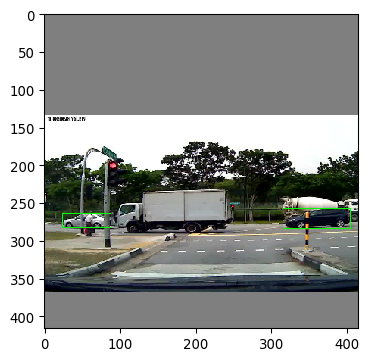

In [194]:
# ia.imshow(newbbs.draw_on_image(testimgs))
ia.imshow(all_objs.draw_on_image(final_img))